## Import Necessary Packages

In [1]:
import h5py
import pickle
import warnings
import numpy as np
import pandas as pd
import proplot as pplt
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

/global/homes/s/sferrett/.conda/envs/monsoon-sr/lib/python3.10/site-packages/proplot/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


## Load Results

In [2]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/'

with open(f'{FILEDIR}/results/pod_results.pkl','rb') as f:
    baseresults = pickle.load(f)
# with open(f'{FILEDIR}/results/nn_results.pkl','rb') as f:
#     mlpresults = pickle.load(f)

with h5py.File(f'{FILEDIR}/processed/data.h5','r') as f:
    ytrue = f['pr_test'][:]

## Functions

In [3]:
def hellinger_distance(p,q):
    minlength = min(len(p),len(q))
    p = p[:minlength]
    q = q[:minlength]
    p = p/np.sum(p)
    q = q/np.sum(q)
    return np.sqrt(0.5*np.sum((np.sqrt(p)-np.sqrt(q))**2))
    
def get_metrics(allmodels,prthresh=0):
    metricsdata = []
    for modelname,results in allmodels.items():
        ytruemodel = results['ytrue']
        ypredmodel = results['ypred']
        r2score = r2_score(ytruemodel,ypredmodel)
        mae  = mean_absolute_error(ytruemodel,ypredmodel)
        mse  = mean_squared_error(ytruemodel,ypredmodel)
        bias = np.mean(ypredmodel-ytruemodel) 
        prthresh   = 0.25
        trueevents = ytruemodel>prthresh
        predevents = ypredmodel>prthresh
        hitrate    = np.sum(trueevents&predevents)/np.sum(trueevents) if np.sum(trueevents)>0 else 0
        far        = np.sum(predevents&~trueevents)/np.sum(predevents) if np.sum(predevents)>0 else 0
        _,_,binedges = create_log_rain_bins()
        histtrue,_ = np.histogram(ytruemodel,bins=binedges,density=True)
        histpred,_ = np.histogram(ypredmodel,bins=binedges,density=True)
        hellinger  = hellinger_distance(histtrue,histpred)
        metricsdata.append({
            'name':modelname,
            'description':results['description'],
            'r2':r2score,
            'mae':mae,
            'mse':mse,
            'bias':bias,
            'hitrate':hitrate,
            'far':far,
            'hellinger':hellinger,
             'nparams':results['nparams']})
    return pd.DataFrame(metricsdata)

def get_model_color(modelname):
    if 'bw_0.1' in modelname:
        return 'red9'   
    elif 'bw_0.01' in modelname:
        return 'red6' 
    elif 'bw_0.001' in modelname:
        return 'red3'  
    elif modelname.startswith('exp_1'):
        return 'pink7'   
    elif modelname.startswith('exp_2'):
        return 'pink'   
    elif modelname.startswith('exp_3'):
        return 'violet7'   
    elif modelname.startswith('exp_4'):
        return 'blue5'    
    elif modelname.startswith('exp_5'):
        return 'teal3'    
    elif modelname.startswith('exp_6'):
        return 'yellow3'   
    else:
        return 'gray6'    

## Clean Precipitation

In [4]:
allmodels = {}

for modelname,results in baseresults.items():
    # validmask = np.isfinite(results['y_pred'])&np.isfinite(ytrue)
    allmodels[modelname] = {
        'description':results['description'],
        'ypred':results['y_pred'], #[validmask],
        'ytrue':ytrue, #[validmask],
        'nparams':results['n_params']}

# for modelname,results in mlpresults.items():
#     # validmask = np.isfinite(results['y_pred'])&np.isfinite(ytrue)
#     allmodels[modelname] = {
#         'description':results['description'],
#         'ypred':results['y_pred'], #[validmask],
#         'ytrue':ytrue, #[validmask],
#         'nparams':results['n_params']}

print(f'Total models loaded: {len(allmodels)}')
print('POD models:',[k for k in allmodels.keys() if k.startswith('bw_')])
# print('NN models:',[k for k in allmodels.keys() if k.startswith('exp_')])

Total models loaded: 3
POD models: ['bw_0.1', 'bw_0.01', 'bw_0.001']


## Plot Actual vs. Predicted Precipitation

In [5]:
allvalues = []
for modelname,results in allmodels.items():
    allvalues.extend(results['ytrue'].flatten())
    allvalues.extend(results['ypred'].flatten())
allvalues = np.asarray(allvalues)
allvalues = allvalues[np.isfinite(allvalues)]
globalmin = np.min(allvalues) 
globalmax = np.max(allvalues)
print(f'Precipitation ranges from {globalmin:.4f} to {globalmax:.2f} mm/day')

Precipitation ranges from 0.0000 to 2934.26 mm/day


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 6492183) + inhomogeneous part.

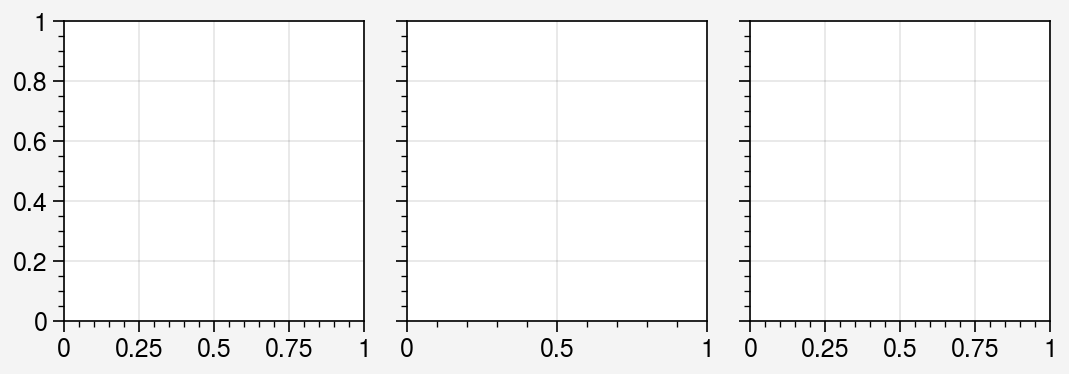

In [6]:
ticks   = [1e-4,1e-2,1e0,1e2]
ncols   = 3
nrows   = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=1.5,share=True)

for i,(modelname,results) in enumerate(allmodels.items()):
    row = i//ncols
    col = i%ncols
    ytruemodel = results['ytrue']
    ypredmodel = results['ypred']
    r2score_val = r2_score(ytruemodel,ypredmodel)
    hist,xedges,yedges = np.histogram2d(ytruemodel,ypredmodel,bins=(50,50))
    hist = np.ma.masked_where(hist==0,hist)
    im = axs[row,col].pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',norm='log',levels=100)
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],'k--',linewidth=1)
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2score_val:.3f}',transform=axs[row,col].transAxes,va='top',ha='left')
    axs[row,col].format(title=results['description'])

for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
    
axs.format(xscale='log',xformatter='log',xlim=[globalmin,globalmax],xticks=ticks,xminorticks='none',
           yscale='log',yformatter='log',ylim=[globalmin,globalmax],yticks=ticks,yminorticks='none')
axs[:,0].format(ylabel='Predicted Precipitation (mm/day)')
axs[-1,:].format(xlabel='Actual Precipitation (mm/day)')

fig.colorbar(im,loc='r',label='Counts')
pplt.show()

## Plot Actual vs. Predicted Distributions

In [ ]:
ncols   = 3
nrows   = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=1.5,share=True)
axs.format(xlabel='Precipitation (mm/day)',yscale='log',yformatter='log')

for i,(modelname,results) in enumerate(allmodels.items()):
    row = i//ncols
    col = i%ncols
    ytruemodel = results['ytrue']
    ypredmodel = results['ypred']
    r2score    = r2_score(ytruemodel,ypredmodel)
    axs[row,col].hist(ytruemodel,bins=100,density=True,histtype='step',color='black',alpha=0.7)
    axs[row,col].hist(ypredmodel,bins=100,density=True,color='red6',alpha=0.7)
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2score:.3f}',transform=axs[row,col].transAxes,va='top',ha='left')
    axs[row,col].format(title=results['description'])
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')

pplt.show()

## Plot Metrics

In [58]:
metricsdf = get_metrics(allmodels)

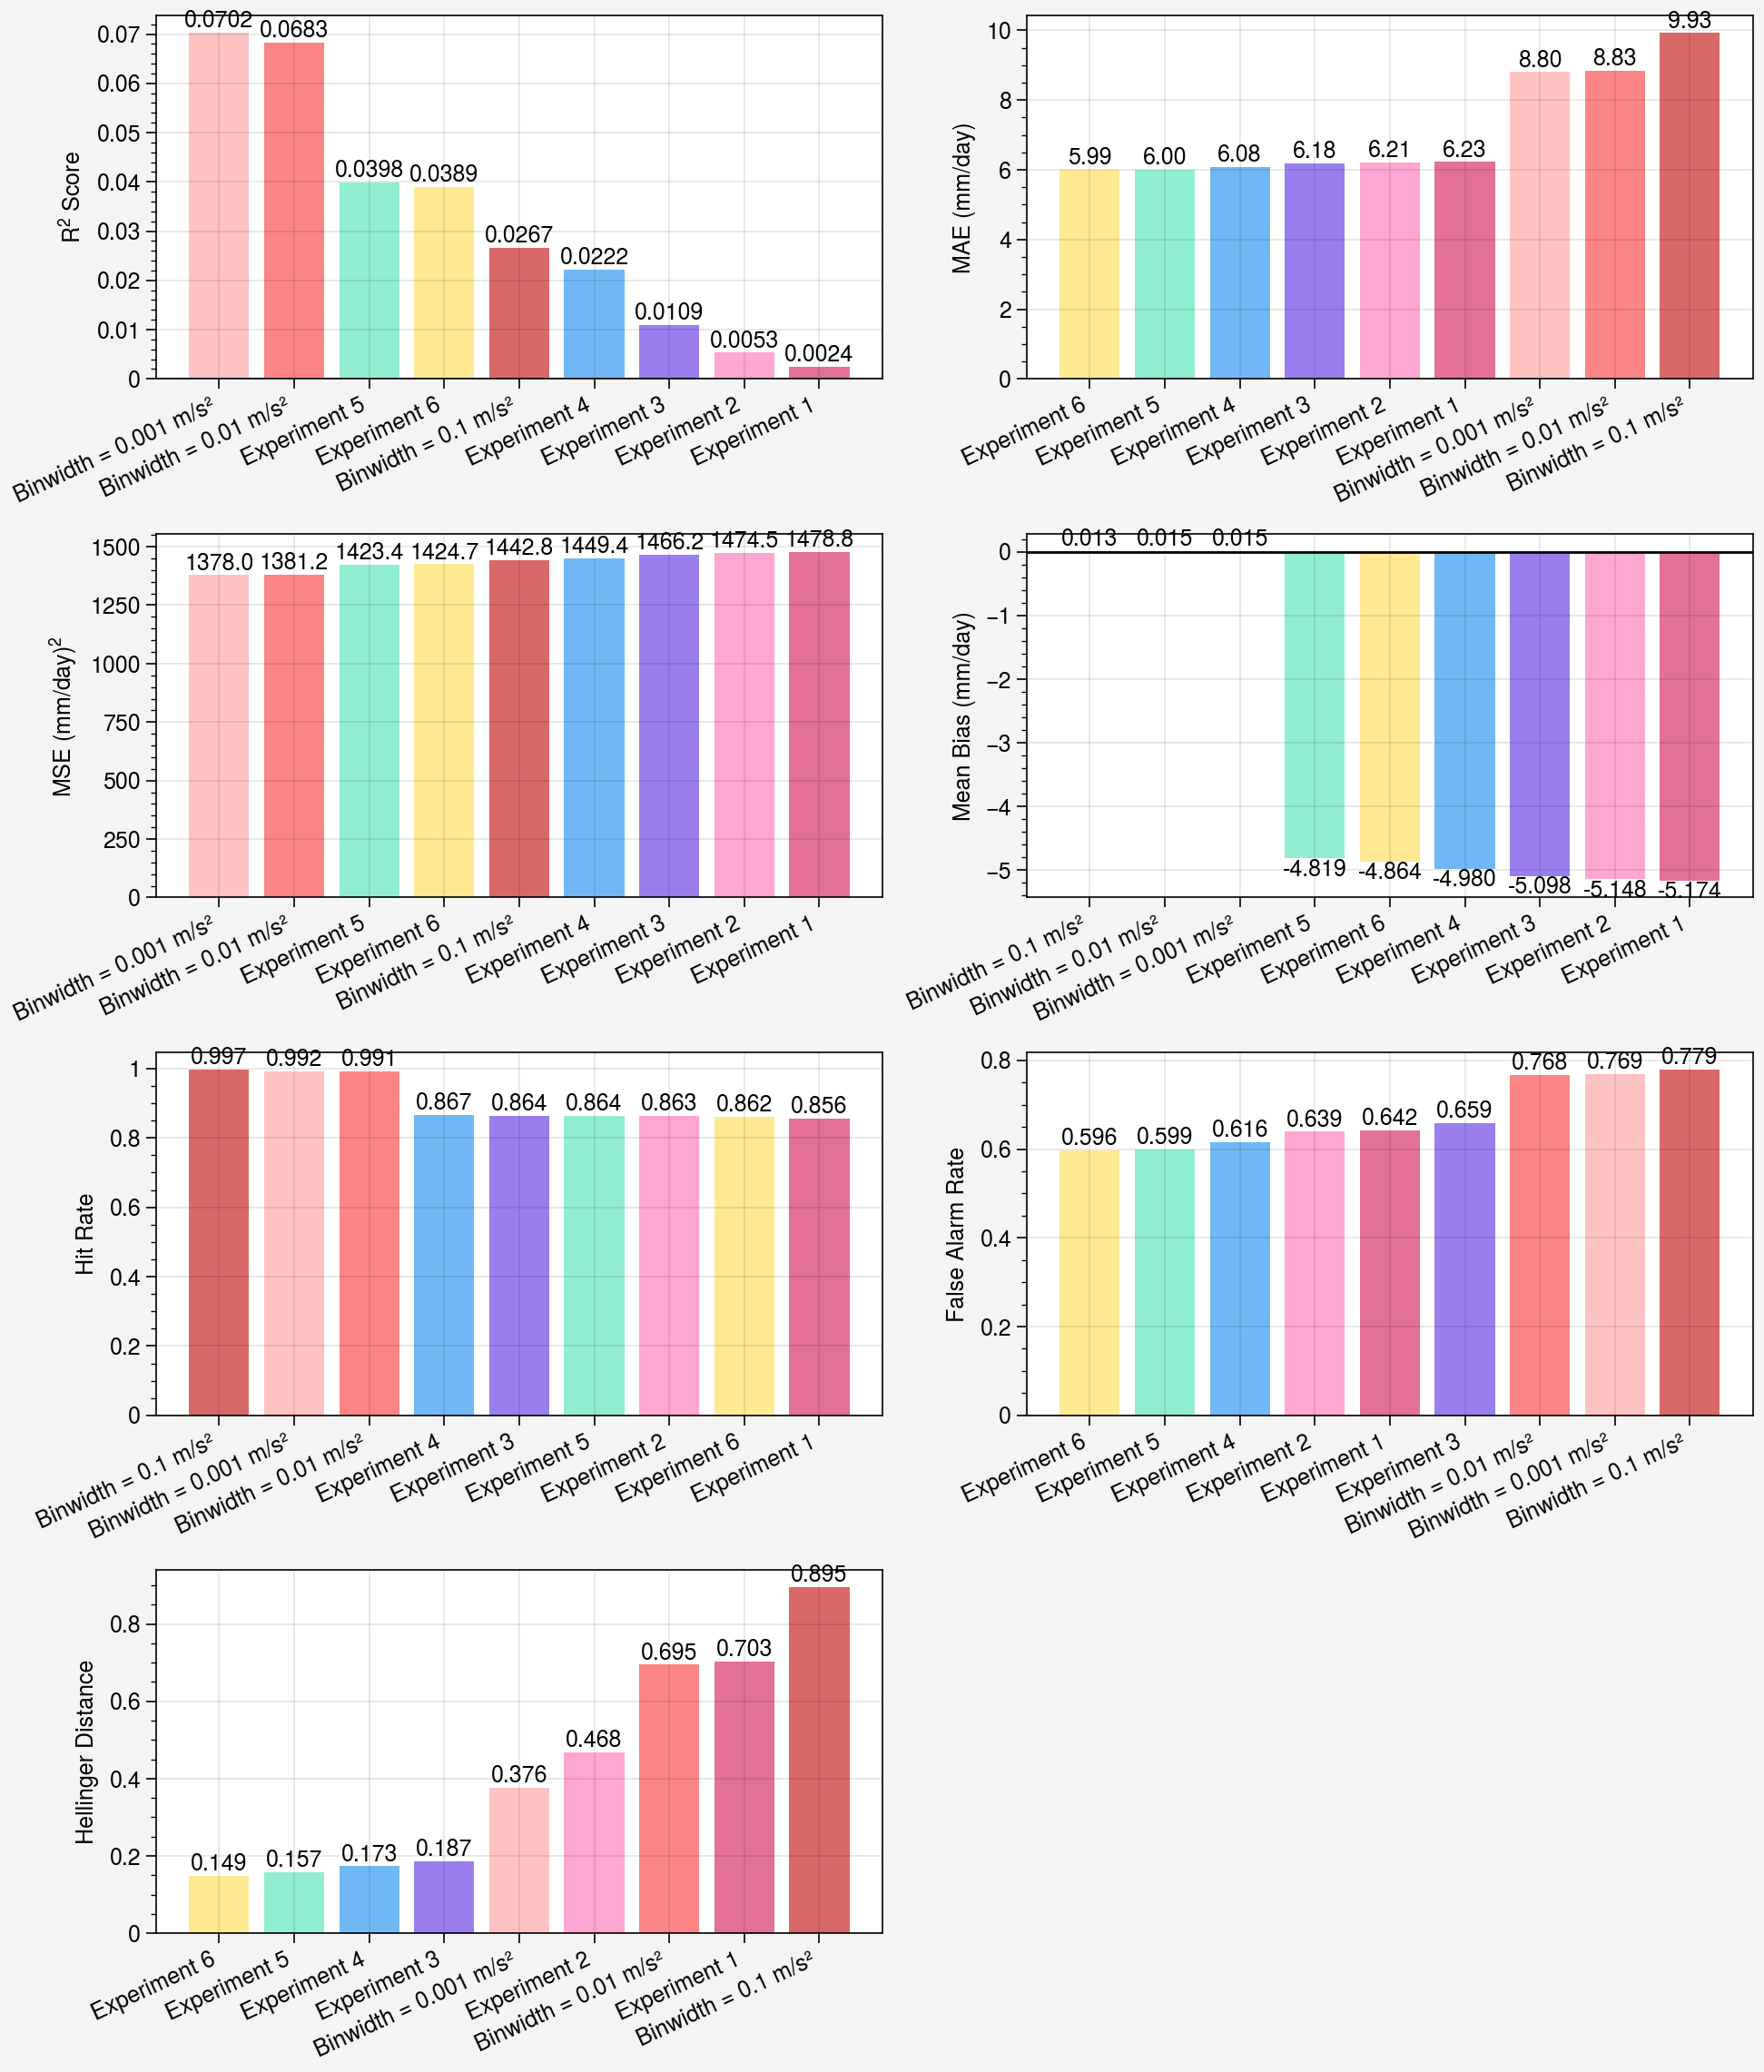

In [59]:
metricsconfig = {
    'r2': {'title':'R$^2$ Score','higher_better':True,'format':'.4f'},
    'mae':{'title':'MAE (mm/day)','higher_better':False,'format':'.2f'},
    'mse':{'title':'MSE (mm/day)$^2$','higher_better':False,'format':'.1f'},
    'bias':{'title':'Mean Bias (mm/day)','higher_better':None,'format':'.3f'},
    'hitrate':{'title':'Hit Rate','higher_better':True,'format':'.3f'},
    'far':{'title':'False Alarm Rate','higher_better':False,'format':'.3f'},
    'hellinger':{'title':'Hellinger Distance','higher_better': False,'format':'.3f'}}

ncols   = 2
nrows   = (len(metricsconfig)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=4,refheight=2,share=False)

for i,(metric,config) in enumerate(metricsconfig.items()):
    row = i//ncols
    col = i%ncols
    if config['higher_better'] is True:
        sorteddf = metricsdf.sort_values(metric, ascending=False)
    elif config['higher_better'] is False:
        sorteddf = metricsdf.sort_values(metric, ascending=True)
    else:
        sorteddf = metricsdf.sort_values(metric, key=abs, ascending=True)
    
    colors = [get_model_color(name) for name in sorteddf['name']]
    bars = axs[row,col].bar(range(len(sorteddf)),sorteddf[metric],color=colors,alpha=0.7)
    axs[row,col].format(ylabel=config['title'],xminorticks='none')
    if metric=='r2' or metric=='bias':
        axs[row,col].axhline(y=0,color='k',linewidth=1)
    
    for j,(bar,value) in enumerate(zip(bars,sorteddf[metric])):
        height = bar.get_height()
        va   = 'bottom' if height>=0 else 'top'
        ypos = height if height>=0 else height
        axs[row,col].text(bar.get_x()+bar.get_width()/2.,ypos,f'{value:{config["format"]}}',ha='center',va=va)
    axs[row,col].set_xticks(range(len(sorteddf)))
    axs[row,col].set_xticklabels([d for d in sorteddf['description']],ha='right',rotation=25)

for i in range(len(metricsconfig),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')

pplt.show()

## Plot Pareto Front

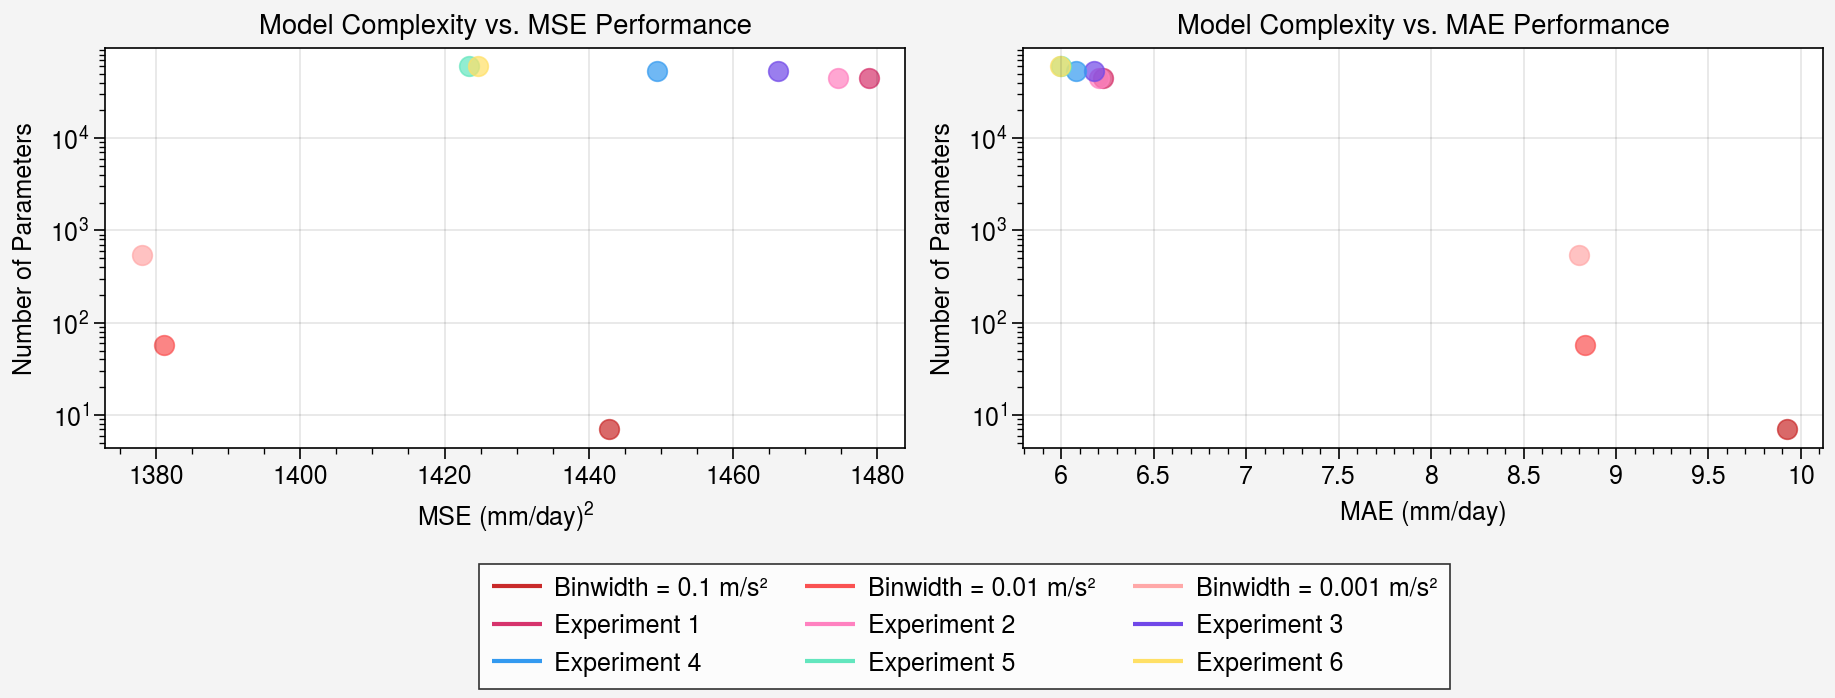

In [64]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,share=False)

axs[0].format(title='Model Complexity vs. MSE Performance',
              xlabel='MSE (mm/day)$^2$',ylabel='Number of Parameters',yscale='log',yformatter='log')
axs[1].format(title='Model Complexity vs. MAE Performance',
              xlabel='MAE (mm/day)',ylabel='Number of Parameters',yscale='log',yformatter='log')

colors  = [get_model_color(name) for name in metricsdf['name']]

elements = []
for i,row in metricsdf.iterrows():
    axs[0].scatter(row['mse'],row['nparams'],color=colors[i],markersize=50,alpha=0.7)
    axs[1].scatter(row['mae'],row['nparams'],color=colors[i],markersize=50,alpha=0.7)
    elements.append(Line2D([0],[0],color=colors[i],markersize=8,label=row['description']))
fig.legend(handles=elements,loc='b',ncols=3)

pplt.show()